# Practical 7: RNN vs CNN
#### Ayoub Bagheri
<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Applied Text Mining - Utrecht Summer School

In this practical, we will try RNN and CNN deep learning architectures. We will work with the famous 20 Newsgroups dataset from the sklearn library to apply deep learning models using the Keras package.

Today we will use the following libraries. Take care to have them installed!

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers, utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

First run the following lines to make your data ready for the models (we used this code in the previous practical):

In [2]:
# select couple of the categories in 20newsgroups
categories = ['rec.sport.hockey', 'talk.politics.mideast', 'soc.religion.christian', 'comp.graphics', 'sci.med']
# fetch the training set
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), 
                                  categories=categories, shuffle=True, random_state=321)
# fetch the test set
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), 
                                 categories=categories, shuffle=True, random_state=321)
# convert to a dataframe
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'label'])
df_test = pd.DataFrame(list(zip(twenty_test.data, twenty_test.target)), columns=['text', 'label'])
# tokenizer from keras
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text.values)
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for sequence padding
# pad sequence
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# Encode the list of newsgroups into categorical integer values
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
y_train = utils.np_utils.to_categorical(y)
y = lb.transform(df_test.label.values)
y_test = utils.np_utils.to_categorical(y)

And here the code to a function for plotting the history of training for our neural network model:

In [3]:
plt.style.use('ggplot')
def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        val_acc = history.history['val_accuracy'] # we can add a validation set in our fit function with nn
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

## Let's get started!

### Recurrent neural networks

A recurrent neural network (RNN) is a natural generalization of feed-forward neural networks to sequence data such as text. In contrast to a feed-forward neural network, however, it accepts a new input at every time step (layer). Long-short term memory (LSTM) networks are a variant of RNNs. The LSTM introduces mechanisms to decide what should be remembered and what should be forgotten in learning from text documents.

1\. **Build a neural network model with an LSTM layer of 100 units. As before, the first layer should be an embedding layer, then the LSTM layer, a Dense layer, and the output Dense layer for the 5 news categories. Compile the model and print its summary.**

In [4]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

embedding_dim = 100
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3811100   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 3,892,565
Trainable params: 3,892,565
Non-trainable params: 0
_________________________________________________________________


The first layer is the Embedded layer that uses 100 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons!). Finally, because this is a classification problem we use a Dense output layer with 5 neurons and a softmax activation function to make 0 or 1 predictions for the five classes.

2\.**Fit the model in 5 epochs.**

In [5]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

3\.**Evaluate the accuracy of training and test data using your model and plot the history of fit.**

Training Accuracy: 0.6855
Testing Accuracy:  0.5950


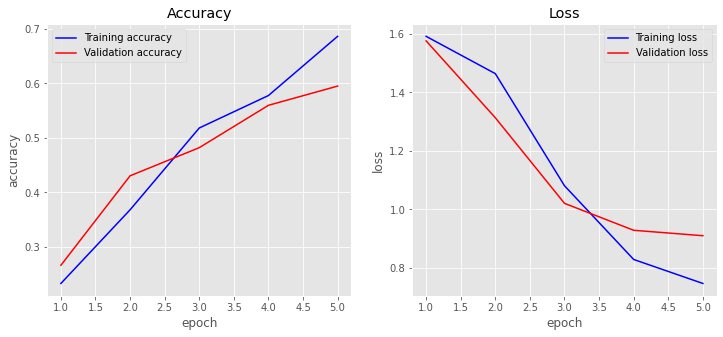

In [6]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Below we trained the model for 20 more epochs. Check the results:

Training Accuracy: 0.8351
Testing Accuracy:  0.6328


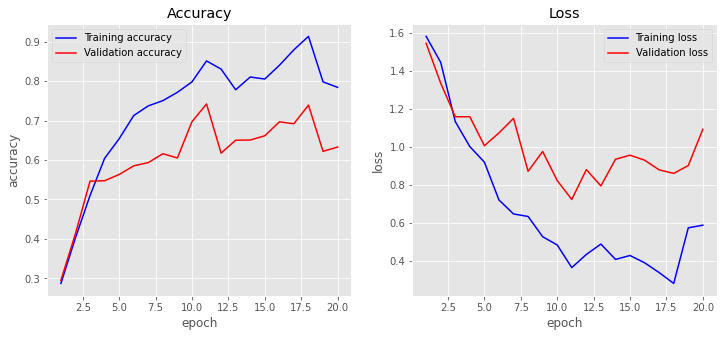

In [7]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

### Convolutional neural networks

Convolutional neural networks or also called convnets are one of the most exciting developments in machine learning in recent years. They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. 


4\. **Build a neural network model with an convolution layer (Conv1D) of 125 units and window size of 5. As before, the first layer should be an embedding layer, then the LSTM layer, a Dense layer, and the output Dense layer for the 5 news categories. Do you also need a pooling layer? Compile the model and print its summary.**

In [8]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          3811100   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 3,876,573
Trainable params: 3,876,573
Non-trainable params: 0
____________________________________________

5\. **Fit the model in 5 epochs, and evaluate the accuracy of the training and test data using your model. Plot the history of the fit.**

Training Accuracy: 0.9497
Testing Accuracy:  0.7799


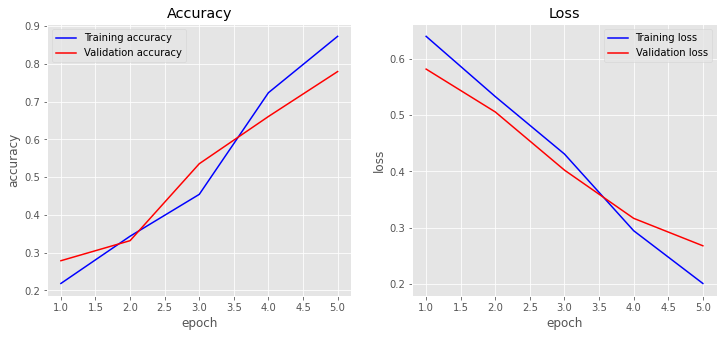

In [9]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Below we trained the model for 10 more epochs. Check the results:

Training Accuracy: 0.9803
Testing Accuracy:  0.8509


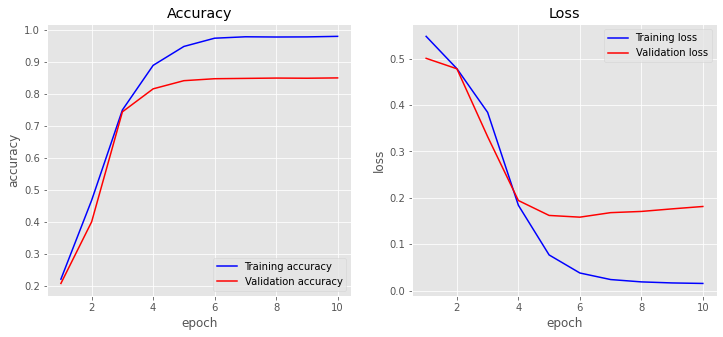

In [10]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

6\. **How do you compare the performance of the two models also with regard to 5 and 20 iterations?**

Look at the plots and discuss your ideas!

# Hyperparameter Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization. Hyperparameters are parameters that are chosen by the algorithm designer. Tuning them is very important!
One popular method for hyperparameter optimization is grid search. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you’ll see in action here, simply takes random combinations of parameters.

7\. **Write function for creating your cnn-based model which has the number of filters, kernel size, and embedding size as input arguments. Name your function create_model. For the rest follow the architecture of your previous cnn model.**

In [11]:
def create_model(num_filters, kernel_size, embedding_dim):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=100))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

8\. **Dictionary in Python is an ordered collection of data values. Use the dict structure to define your hyperparameters for the cnn model. You can include the number of filters, kernel size, and embedding size.**

In [12]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],                   
                  embedding_dim=[50, 100])

When constructing this structure you must provide a dictionary of hyperparameters to evaluate in the param_grid argument. This is a map of the model parameter name and an array of values to try.

9\. **Use the scikit-learn classifier API for Keras to create your model with the create_model function, 15 epochs, and batch_size of 64.**

In [13]:
# Parameter grid for grid search
# KerasClassifier: old version, Sci-Keras: new version
model = KerasClassifier(build_fn=create_model,
                  epochs = 15,
                  batch_size=64,
                  verbose=True)

C:\Users\ayoub\AppData\Local\Temp\ipykernel_25848\1410109026.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model,


10\. **Time to call the RandomizedSearchCV function. Use your model, your selected grid for hyperparameters, and 5-fold cross-validation.**

In [14]:
grid = RandomizedSearchCV(estimator=model, 
                          param_distributions=param_grid,
                          cv=5, 
                          n_jobs=-1,
                          verbose=1, 
                          n_iter=2)

As you see in this function, there are more input arguments which you can set including n_jobs and n_iter. By default, the random search (or grid search) will only use one thread. By setting the n_jobs argument in the RandomizedSearchCV (or GridSearchCV) constructor to -1, the process will use all cores on your machine.
It is also worth mentioning that by default, accuracy is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

11\. **Fit your grid on X_train and y_train.**

In [15]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/15
46/46 [==============================] - 2s 37ms/step - loss: 0.6758 - accuracy: 0.2040
Epoch 2/15
46/46 [==============================] - 2s 34ms/step - loss: 0.6181 - accuracy: 0.2040
Epoch 3/15
46/46 [==============================] - 2s 34ms/step - loss: 0.5505 - accuracy: 0.2353
Epoch 4/15
46/46 [==============================] - 2s 33ms/step - loss: 0.4658 - accuracy: 0.4148
Epoch 5/15
46/46 [==============================] - 2s 33ms/step - loss: 0.3016 - accuracy: 0.7283
Epoch 6/15
46/46 [==============================] - 2s 33ms/step - loss: 0.1896 - accuracy: 0.9187
Epoch 7/15
46/46 [==============================] - 1s 30ms/step - loss: 0.1115 - accuracy: 0.9626 0s - loss: 0
Epoch 8/15
46/46 [==============================] - 2s 33ms/step - loss: 0.0651 - accuracy: 0.9738
Epoch 9/15
46/46 [==============================] - 1s 32ms/step - loss: 0.0412 - accuracy: 0.9769
Epoch 10/15
46/46 [=================

12\. **Find the best scores and the best values for the hyperparameters.**

In [16]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.831006669998169
{'num_filters': 32, 'kernel_size': 3, 'embedding_dim': 100}


The best_score_ member provides access to the best score observed during the optimization procedure and the best_params_ describes the combination of parameters that achieved the best results.

13\. **Evaluate the performance on the test set.**

In [17]:
test_accuracy = grid.score(X_test, y_test)
test_accuracy

31/31 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.8064


0.8064351081848145

**Now you can use the best hyperparameter values to build your final model. Do that as your fun homework!**